This file will run an LSTM model to predict the electricity prices. 

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from functions import plot_comparison, evaluate_lstm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [2]:
df = pd.read_csv('../../Data/zra_sgp_dam.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Defining Functions

In [3]:
def encode_cyclic(df, col, max_val):
    """"
    Time features like Hour, Month, day_of_week are cyclical, not linear. 
    Without encoding them properly, the model will misunderstand their relationships.
    """
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

def preprocess(df):
    df = df.copy()
    
    # Cyclic encode time features
    df = encode_cyclic(df, 'Hour', 24)
    df = encode_cyclic(df, 'Month', 12)
    df = encode_cyclic(df, 'day_of_week', 7)
    
    # Drop unused or problematic columns
    df = df.drop(columns=['Hour', 'Month', 'day_of_week'])  # Keep cyclic versions instead
    
    # Fill/clean if needed
    df = df.fillna(method='ffill').dropna()
    
    return df

In [4]:
# Create sequence for LSTM
def create_sequences(data, target_col, n_steps=48, forecast_horizon=24):
    X, y = [], []
    for i in range(len(data) - n_steps - forecast_horizon):
        seq_x = data.iloc[i:i+n_steps].drop(columns=[target_col]).values
        seq_y = data.iloc[i+n_steps:i+n_steps+forecast_horizon][target_col].values
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
# Dataset and DataLoader
class PriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [6]:
# Lstm model
class LSTMForecast(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2, output_size=24):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, _ = self.lstm(x) # Get all outputs
        out = output[:, -1, :] # Use output from the last timestep
        return self.fc(out)

In [7]:
import torch
import torch.nn as nn

class LogCoshLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true):
        loss = torch.log(torch.cosh(y_pred - y_true + 1e-12))  # added epsilon to prevent log(0)
        return torch.mean(loss)


In [8]:
import copy
import torch

def train_model(model, dataloader, val_dataloader=None, epochs=10, lr=1e-3, patience=10, min_delta=1e-4):
    device = next(model.parameters()).device
    criterion = LogCoshLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')
    best_model_state = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)

        if val_dataloader:
            model.eval()
            val_total_loss = 0
            with torch.no_grad():
                for xb, yb in val_dataloader:
                    xb, yb = xb.to(device), yb.to(device)
                    pred = model(xb)
                    loss = criterion(pred, yb)
                    val_total_loss += loss.item()

            avg_val_loss = val_total_loss / len(val_dataloader)
            val_loss_history.append(avg_val_loss)

            if best_val_loss - avg_val_loss > min_delta:
                best_val_loss = avg_val_loss
                best_model_state = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break
        else:
            print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    if val_dataloader:
        model.load_state_dict(best_model_state)

    return loss_history, val_loss_history if val_dataloader else loss_history


In [9]:
def plot_loss(loss_history):
    plt.figure(figsize=(10, 4))
    plt.plot(loss_history, label='Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss per Epoch')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [10]:
def plot_shap_importance(importances, feature_names=None):
    import matplotlib.pyplot as plt
    import numpy as np

    indices = np.argsort(importances)[::-1]
    names = list(feature_names) if feature_names is not None else [f"Feature {i}" for i in range(len(importances))]

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [names[i] for i in indices], rotation=45, ha='right')
    plt.title("SHAP Feature Importance (Averaged)")
    plt.tight_layout()
    plt.show()


In [11]:
def predict_from_datetime(model, df, timestamp, n_steps=48, target_col='Price (USD/MWh)', scaler_y=None):
    """
    Predict 24-hour prices starting from a given timestamp.

    Args:
        model: Trained LSTMForecast model.
        df: Preprocessed + scaled DataFrame (with DateTime index).
        timestamp: Datetime string or pd.Timestamp (e.g. '2023-01-01 00:00').
        n_steps: Number of past hours to use (default = 48).
        target_col: Name of target column.
        scaler_y: Scaler used for the target column.

    Returns:
        List of (datetime, predicted_price) tuples.
    """
    if isinstance(timestamp, str):
        timestamp = pd.Timestamp(timestamp)
        
    # Check if enough history is available
    start_idx = df.index.get_loc(timestamp)
    if start_idx < n_steps:
        raise ValueError("Not enough history before this timestamp.")

    # Build the input sequence (excluding target columns)
    seq_df = df.iloc[start_idx - n_steps:start_idx].drop(columns=[target_col, 'target_scaled'])
    seq_input = seq_df.values  # shape: (n_steps, num_features)

    # Predict the future prices
    model.eval()
    with torch.no_grad():
        x = torch.tensor(seq_input[np.newaxis, :, :], dtype=torch.float32)
        y_pred = model(x).squeeze().numpy()  # shape: (forecast_horizon, )

    # Reverse scaling (if provided)
    if scaler_y is not None:
        y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))  # Inverse transform predictions
        y_pred_original_flat = y_pred_original.flatten()  # Flatten to 1D
    else:
        y_pred_original_flat = y_pred  # If no scaler, use raw predictions

    # Build future timestamps
    future_times = [timestamp + pd.Timedelta(hours=i) for i in range(24)]
    
    return list(zip(future_times, y_pred_original_flat))


# Training model

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Preprocess (make sure 'Date' becomes index)
df_clean = preprocess(df)

# Define target
target_col = 'Price (USD/MWh)'
features = df_clean.drop(columns=[target_col])
target = df_clean[target_col]

# Columns by type
minmax_cols = ['Tati- normalised output', 'E_Grid (Mw)', 'Revenues (USD)', 
               'Flow_chavuma', 'Level_kariba', 'Flow_nana']
standard_cols = ['Volatility_1 Day', 'Volatility_3 Days', 'Volatility_7 Days', 'Volatility_30 Days',
                 'roc_49h', 'momentum_49h']
no_scaling_cols = ['Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos',
                   'day_of_week_sin', 'day_of_week_cos']

# Initialize scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
scaler_y = MinMaxScaler()

# Copy clean DataFrame
df_scaled = df_clean.copy()

# Apply scalers to appropriate columns
df_scaled[minmax_cols] = minmax_scaler.fit_transform(df_clean[minmax_cols])
df_scaled[standard_cols] = standard_scaler.fit_transform(df_clean[standard_cols])

# Target scaling (fit only on the column, keep shape)
df_scaled["target_scaled"] = scaler_y.fit_transform(df_clean[[target_col]])

# Optionally retain unscaled target for reference
df_scaled[target_col] = target


/scratch-local/krasmussen.12138935/ipykernel_3081643/4031471906.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').dropna()


In [13]:
class LazyPriceDataset(Dataset):
    def __init__(self, df, target_col, lookback, forecast_horizon):
        self.lookback = lookback
        self.forecast_horizon = forecast_horizon
        self.target_col = target_col

        self.features = df.drop(columns=[target_col]).values
        self.target = df[target_col].values

    def __len__(self):
        return len(self.features) - self.lookback - self.forecast_horizon + 1

    def __getitem__(self, idx):
        x = self.features[idx : idx + self.lookback]
        y = self.target[idx + self.lookback : idx + self.lookback + self.forecast_horizon]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [51]:
lookback = 24 * 90 # 30 days of history
forecast_horizon = 24

# Kernel will crash otherwise due to memory
if lookback >= 2160:
    total_len = len(df_scaled)
    train_end = int(0.7 * total_len)
    val_end = int(0.85 * total_len)

    df_train = df_scaled.drop(columns=['Price (USD/MWh)']).iloc[:train_end]
    df_val = df_scaled.drop(columns=['Price (USD/MWh)']).iloc[train_end:]
    df_test = df_scaled.drop(columns=['Price (USD/MWh)']).iloc[val_end:]

    train_ds = LazyPriceDataset(df_train, target_col='target_scaled', lookback=lookback, forecast_horizon=forecast_horizon)
    val_ds   = LazyPriceDataset(df_val,   target_col='target_scaled', lookback=lookback, forecast_horizon=forecast_horizon)
    test_ds  = LazyPriceDataset(df_test,  target_col='target_scaled', lookback=lookback, forecast_horizon=forecast_horizon)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=False, num_workers=0)
    val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=0)
    # After creating train_loader (lazy or not)
    sample_batch = next(iter(train_loader))
    # Create a *dummy* X with the right shape but no data copying
    X = torch.empty((len(train_loader.dataset),) + sample_batch[0].shape[1:])

else:
    # Create sequences
    X, y = create_sequences(df_scaled.drop(columns=['Price (USD/MWh)']), target_col='target_scaled', n_steps=lookback, forecast_horizon=24)

    # Train-validation-test split (70-15-15 split)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

    # Create datasets
    train_ds = PriceDataset(X_train, y_train)
    val_ds = PriceDataset(X_val, y_val)
    test_ds = PriceDataset(X_test, y_test)

    # Create DataLoaders
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=False, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=0)

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
import numpy as np
from random import uniform
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

# Assuming LSTMForecast and train_ds are defined elsewhere
# Also assuming val_loader is defined somewhere

input_size = X.shape[2]  # Number of features (should match the input size of the LSTM)

class WOA:
    def __init__(self, n_whales, max_iter, bounds):
        self.n_whales = n_whales
        self.max_iter = max_iter
        self.bounds = bounds
        self.population = self.init_population()
        self.best_whale = None
        self.best_fitness = float('inf')

    def init_population(self):
        """Initialize whale population randomly within the specified bounds."""
        population = []
        for _ in range(self.n_whales):
            whale = [uniform(*self.bounds[param]) for param in self.bounds]
            population.append(whale)
        return population

    def smape(self, y_true, y_pred):
        """Symmetric Mean Absolute Percentage Error"""
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
        smape = np.mean(np.abs(y_pred - y_true) / denominator) * 100
        return smape
    
    def evaluate_model(self, model, val_loader, device):
        """Evaluate the model on the validation set."""
        model.to(device)  # Ensure model is on the correct device (GPU or CPU)
        model.eval()  # Set the model to evaluation mode
        y_true = []
        y_pred = []

        with torch.no_grad():  # No gradient calculation needed during evaluation
            for xb, yb in val_loader:  # Iterate over validation data
                xb, yb = xb.to(device), yb.to(device)  # Move data to the correct device
                output = model(xb)  # Model's predictions

                y_true.append(yb.cpu().numpy())  # Store actual values
                y_pred.append(output.cpu().numpy())  # Store predicted values

        # Flatten the lists into 1D arrays for easy SMAPE calculation
        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)

        return y_true, y_pred

    def fitness(self, whale):
        """Calculate fitness (SMAPE) of the current whale configuration."""
        hidden_size, num_layers, dropout, lr = whale

        N_subset = 8760 - lookback
        subset_indices = list(range(N_subset))
        subset_train_ds = torch.utils.data.Subset(train_ds, subset_indices)
        subset_train_loader = DataLoader(subset_train_ds, batch_size=64, shuffle=True)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        model = LSTMForecast(
            input_size=input_size,
            hidden_size=int(hidden_size),
            num_layers=int(num_layers),
            dropout=dropout,
            output_size=24
        ).to(device)  # Move the model to the correct device

        # Get actuals and predictions from validation
        y_true, y_pred = self.evaluate_model(model, val_loader, device)

        return self.smape(y_true, y_pred)


    def update_position(self, whale, a, best_whale):
        """Update the position of the whale based on the hunting behavior."""
        A = 2 * a * np.random.rand() - a  # Randomization for exploration
        C = 2 * np.random.rand()  # Another randomization factor for exploration
        p = np.random.rand()  # Probability for exploitation or exploration

        if p < 0.5:
            if np.abs(A) >= 1:
                # Exploration: Random movement
                rand_whale = self.population[np.random.randint(self.n_whales)]
                new_whale = np.array(rand_whale) - A * np.abs(C * np.array(rand_whale) - np.array(whale))
            else:
                # Exploitation: Move towards best whale
                new_whale = np.array(best_whale) - A * np.abs(C * np.array(best_whale) - np.array(whale))
        else:
            distance_best = np.abs(np.array(best_whale) - np.array(whale))
            new_whale = distance_best * np.exp(a * distance_best) * np.cos(2 * np.pi * np.random.rand())

        # Bound check: Ensure the new whale is within bounds
        new_whale = np.clip(new_whale, [self.bounds[param][0] for param in self.bounds],
                            [self.bounds[param][1] for param in self.bounds])
        
        return new_whale

    def optimize(self, smape_threshold=10.0):
        """Run the Whale Optimization Algorithm."""
        for t in tqdm(range(self.max_iter), desc="WOA Iterations"):
            a = 2 - t * (2 / self.max_iter)

            for i in tqdm(range(self.n_whales), desc=f"Whales (Iteration {t+1})", leave=False):
                whale = self.population[i]
                hidden_size, num_layers, dropout, lr = whale

                # print(f"Iteration {t+1}, Whale {i+1}: hidden_size={int(hidden_size)}, "
                #       f"num_layers={int(num_layers)}, dropout={dropout:.3f}, lr={lr:.6f}")

                fitness_val = self.fitness(whale)

                if fitness_val < self.best_fitness:
                    self.best_fitness = fitness_val
                    self.best_whale = whale

                    # Early stopping if precision threshold met
                    if self.best_fitness <= smape_threshold:
                        # print(f"\nStopping early at iteration {t+1} with SMAPE {self.best_fitness:.2f}")
                        return self.best_whale, self.best_fitness

                self.population[i] = self.update_position(whale, a, self.best_whale)

        return self.best_whale, self.best_fitness


# Define the bounds for the hyperparameters
bounds = {
    'hidden_size': (32, 256),  # Increased hidden size range to 256
    'num_layers': (1, 4),      # Increased num_layers range to 4
    'dropout': (0.1, 0.5),     # Increased dropout range to 0.5
    'lr': (5e-4, 1e-2)         # Increased learning rate range to 1e-2
}

# Create the WOA optimizer with the updated bounds
woa = WOA(n_whales=10, max_iter=50, bounds=bounds)


# Run optimization
best_params, best_val_loss = woa.optimize()

# Output the best found parameters and corresponding validation loss
print("\nBest configuration from WOA:")
print(f"Best Params: {best_params}")
print(f"Best Validation Loss: {best_val_loss}")


WOA Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

WOA Iterations: 100%|██████████| 50/50 [1:31:07<00:00, 109.35s/it]


Best configuration from WOA:
Best Params: [3.2e+01 1.0e+00 1.0e-01 5.0e-04]
Best Validation Loss: 118.08260679244995


In [54]:
best_params = [32,1,0,0.0005]

⏹️ Early stopping at epoch 48

Training completed in 958.83 seconds.


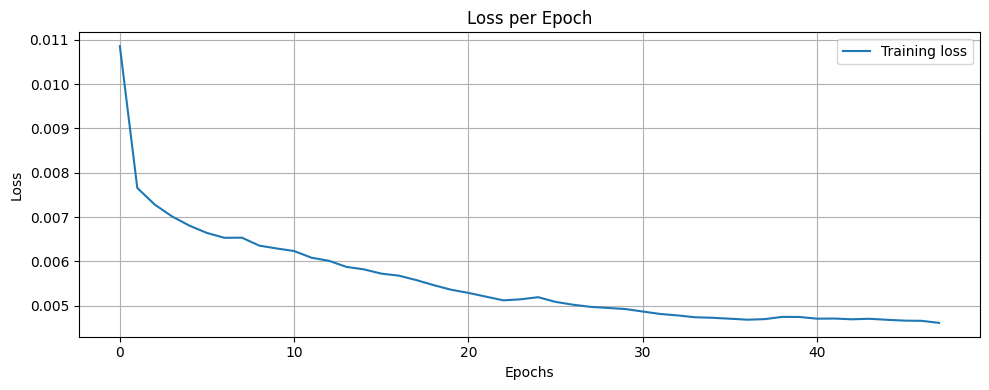

In [55]:
"Train model with best params from WOA"
import time  # Add this at the top of your script if not already imported
# Model
input_size = X.shape[2]  # Number of features (should match the input size of the LSTM)

model = LSTMForecast(
    input_size=input_size,
    hidden_size=int(best_params[0]),  # Ensure integer value for hidden_size
    num_layers=int(best_params[1]),   # Ensure integer value for num_layers
    dropout=best_params[2],
    output_size=24
).to(device)

# Train the model with timing
start_time = time.time()

train_losses, val_losses = train_model(
    model,
    dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=100,
    lr=best_params[3],
    patience=15,       # stop if no val improvement
    min_delta=1e-4     # must improve by at least this much
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTraining completed in {elapsed_time:.2f} seconds.")

plot_loss(train_losses)


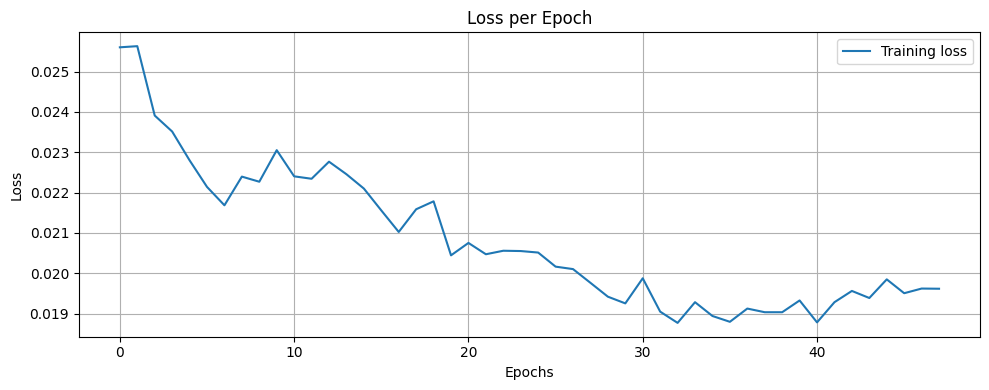

In [56]:
plot_loss(val_losses)

In [57]:
print(best_params)

[32, 1, 0, 0.0005]


# Model Evaluation 

In [58]:
model.eval()
y_val_preds, y_val_true = [], []
y_test_preds, y_test_true = [], []

with torch.no_grad():
    if lookback >= 2160:
        # Lazy: batch-by-batch prediction
        for xb, yb in val_loader:
            xb = xb.to(device)
            preds = model(xb)
            y_val_preds.append(preds.cpu())
            y_val_true.append(yb.cpu())

        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb)
            y_test_preds.append(preds.cpu())
            y_test_true.append(yb.cpu())

        y_val_pred = torch.cat(y_val_preds).numpy()
        y_val = torch.cat(y_val_true).numpy()
        y_test_pred = torch.cat(y_test_preds).numpy()
        y_test = torch.cat(y_test_true).numpy()

    else:
        # Eager mode
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_val_pred = model(X_val_tensor).cpu().numpy()
        y_test_pred = model(X_test_tensor).cpu().numpy()

# Reverse scaling
y_val_pred_original = scaler_y.inverse_transform(y_val_pred)
y_test_pred_original = scaler_y.inverse_transform(y_test_pred)

y_val_original = scaler_y.inverse_transform(y_val.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Flatten
y_val_pred_original_flat = y_val_pred_original.flatten()
y_test_pred_original_flat = y_test_pred_original.flatten()
y_val_flat = y_val_original.flatten()
y_test_flat = y_test_original.flatten()


In [59]:
# Create datetime index from original DataFrame
start_date = df.index.min()
end_date = df.index.max()
all_datetimes = pd.date_range(start=start_date, end=end_date, freq='h')
N_total = len(all_datetimes)

# Recalculate split indices
train_size = int(0.7 * N_total)
val_size = int(0.15 * N_total)
val_start = train_size
val_end = train_size + val_size
test_start = val_end

In [60]:
# Generate datetime index for predictions
val_index_expanded = pd.date_range(start=all_datetimes[val_start], periods=len(y_val_flat), freq='h')
test_index_expanded = pd.date_range(start=all_datetimes[test_start], periods=len(y_test_flat), freq='h')

# Create DataFrames for evaluation
X_val_df = pd.DataFrame(index=val_index_expanded)
X_test_df = pd.DataFrame(index=test_index_expanded)


In [61]:
# Create datetime index from original DataFrame
start_date = df.index.min()
end_date = df.index.max()
all_datetimes = pd.date_range(start=start_date, end=end_date, freq='h')
N_total = len(all_datetimes)

# Recalculate split indices
train_size = int(0.7 * N_total)
val_size = int(0.15 * N_total)
val_start = train_size
val_end = train_size + val_size
test_start = val_end

In [62]:
import plotly.graph_objects as go

def plot_predictions(
    y_true, y_pred, df_index,
    start_time="2023-08-01 00:00:00",
    n_hours=500,
    error_threshold=15
):
    # Convert inputs
    start_time = pd.to_datetime(start_time)

    # Build aligned DataFrame
    df = pd.DataFrame({
        'actual': y_true,
        'predicted': y_pred
    }, index=pd.to_datetime(df_index))

    # Slice the time range
    df_slice = df.loc[start_time : start_time + pd.Timedelta(hours=n_hours)]

    # Calculate error
    df_slice['error'] = abs(df_slice['actual'] - df_slice['predicted'])

    # Identify high error regions
    high_error_mask = df_slice['error'] > error_threshold

    # Create Plotly figure
    fig = go.Figure()

    # Actual values (Deep blue)
    fig.add_trace(go.Scatter(
        x=df_slice.index, y=df_slice['actual'],
        mode='lines', name='True',
        line=dict(color='#1f77b4', width=2)
    ))

    # Predicted values (Soft green)
    fig.add_trace(go.Scatter(
        x=df_slice.index, y=df_slice['predicted'],
        mode='lines', name='Predicted',
        line=dict(color='#2ca02c', width=2)
    ))

    # High-error markers (Bold red)
    if high_error_mask.any():
        fig.add_trace(go.Scatter(
            x=df_slice.index[high_error_mask],
            y=df_slice['predicted'][high_error_mask],
            mode='markers',
            marker=dict(size=6, color='#d62728', symbol='circle'),
            name=f'Error > {error_threshold}',
            text=[f"Error: {e:.2f}" for e in df_slice['error'][high_error_mask]],  # Hover text
            hoverinfo='text+x+y',
            showlegend=True
        ))

    # Layout styling
    fig.update_layout(
        title=f"LSTM Forecast from {start_time.strftime('%Y-%m-%d %H:%M')} ({n_hours} hours)",
        xaxis_title="Time",
        yaxis_title="Value",
        template="plotly_white",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        height=500,
        margin=dict(l=40, r=40, t=60, b=40)
    )

    fig.show()

In [63]:
# plot_predictions(
#     y_true=y_val_flat,
#     y_pred=y_val_pred_original_flat,
#     df_index=X_val_df.index,
#     start_time="2023-08-01 00:00:00",
#     n_hours=500
# )

In [64]:
# --- Evaluate model ---
results = evaluate_lstm(
    y_val=y_val_flat,
    y_val_pred=y_val_pred_original_flat,
    y_test=y_test_flat,
    y_test_pred=y_test_pred_original_flat,
    X_val=X_val_df,
    X_test=X_test_df)

print(results)

           Metric        MAE        DAE       RMSE        R2  \
0  Validation Set  56.065937  42.526356  78.559287  0.192773   
1        Test Set  61.281666  51.803967  85.481789  0.007204   

   Lower Predictions (%)  
0              61.939171  
1              78.189097  


In [65]:
def predict_from_datetime(model, df, timestamp, n_steps=48, target_col='Price (USD/MWh)', scaler_y=None):
    """
    Predict 24-hour prices starting from a given timestamp.

    Args:
        model: Trained LSTMForecast model.
        df: Preprocessed + scaled DataFrame (with DateTime index).
        timestamp: Datetime string or pd.Timestamp (e.g. '2023-01-01 00:00').
        n_steps: Number of past hours to use (default = 48).
        target_col: Name of target column.
        scaler_y: Scaler used for the target column.

    Returns:
        List of (datetime, predicted_price) tuples.
    """
    if isinstance(timestamp, str):
        timestamp = pd.Timestamp(timestamp)
        
    # Check if enough history is available
    start_idx = df.index.get_loc(timestamp)
    if start_idx < n_steps:
        raise ValueError("Not enough history before this timestamp.")

    # Build the input sequence (excluding target columns)
    seq_df = df.iloc[start_idx - n_steps:start_idx].drop(columns=[target_col, 'target_scaled'])
    seq_input = seq_df.values  # shape: (n_steps, num_features)

    # Predict the future prices
    model.eval()
    with torch.no_grad():
        x = torch.tensor(seq_input[np.newaxis, :, :], dtype=torch.float32)
        y_pred = model(x).squeeze().numpy()  # shape: (forecast_horizon, )

    # Reverse scaling (if provided)
    if scaler_y is not None:
        y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))  # Inverse transform predictions
        y_pred_original_flat = y_pred_original.flatten()  # Flatten to 1D
    else:
        y_pred_original_flat = y_pred  # If no scaler, use raw predictions

    # Build future timestamps
    future_times = [timestamp + pd.Timedelta(hours=i) for i in range(24)]
    
    return list(zip(future_times, y_pred_original_flat))


In [66]:
preds = predict_from_datetime(model, df_scaled, '2024-01-01 00:00',scaler_y=scaler_y)

for t, price in preds:
    print(f"{t}: ${price:.2f}")

RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cpu and parameter tensor at cuda:0

#  Post-Hoc Interpretability with Integrated Gradients (XAI)
To understand how the LSTM model arrives at its predictions, we apply post-hoc interpretability methods—techniques used after model training to explain behavior without altering the model itself. One such method is Integrated Gradients, which attributes importance scores to input features based on their contribution to a specific prediction. This approach is particularly valuable for complex, black-box models like LSTMs, where internal mechanisms are not easily interpretable. By applying Integrated Gradients, we gain insights into both individual decisions (local interpretation) and broader model behavior (global interpretation), helping to build transparency, trust, and accountability in the forecasting process.


## Local Interpretation
The local interpretation using Integrated Gradients provides insight into which input features most influenced the model’s prediction for a specific timestamp. By attributing importance values to each feature in that one sample, we can understand the direction (positive or negative) and magnitude of their impact on the predicted price. This helps explain the model's reasoning at an individual decision level — for example, highlighting that high 7-day volatility or weekend timing pushed the forecast upward in that particular context.

In [67]:
X_model_input = df_scaled.drop(columns=['Price (USD/MWh)', 'target_scaled'])
model_feature_names = X_model_input.columns.tolist()

print("Number of model features:", len(model_feature_names))  # Should be 34
print("Model features:", model_feature_names)

# Confirm if it's just a mismatch in your feature_names list
missing = set(model_feature_names) - set(feature_names)
print("Missing from feature_names:", missing)


Number of model features: 33
Model features: ['Tati- normalised output', 'E_Grid (Mw)', 'Revenues (USD)', 'Volatility_1 Day', 'Volatility_3 Days', 'Volatility_7 Days', 'Volatility_30 Days', 'Flow_chavuma', 'Level_kariba', 'Flow_nana', 'Flow_ngonye', 'GlobHor (W/m²)', 'DiffHor (W/m²)', 'T_Amb (°C)', 'GlobInc (W/m²)', 'EArray (kW)', 'E_Grid (kW)', 'PR (ratio)', 'AO (in %)', 'is_weekend', 'price_lag1d', 'price_lag7d', 'price_lag14d', 'ema_22h', 'ema_168h', 'roc_49h', 'momentum_49h', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'day_of_week_sin', 'day_of_week_cos']
Missing from feature_names: set()


In [68]:
df_scaled.columns

Index(['Price (USD/MWh)', 'Tati- normalised output', 'E_Grid (Mw)',
       'Revenues (USD)', 'Volatility_1 Day', 'Volatility_3 Days',
       'Volatility_7 Days', 'Volatility_30 Days', 'Flow_chavuma',
       'Level_kariba', 'Flow_nana', 'Flow_ngonye', 'GlobHor (W/m²)',
       'DiffHor (W/m²)', 'T_Amb (°C)', 'GlobInc (W/m²)', 'EArray (kW)',
       'E_Grid (kW)', 'PR (ratio)', 'AO (in %)', 'is_weekend', 'price_lag1d',
       'price_lag7d', 'price_lag14d', 'ema_22h', 'ema_168h', 'roc_49h',
       'momentum_49h', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos',
       'day_of_week_sin', 'day_of_week_cos', 'target_scaled'],
      dtype='object')

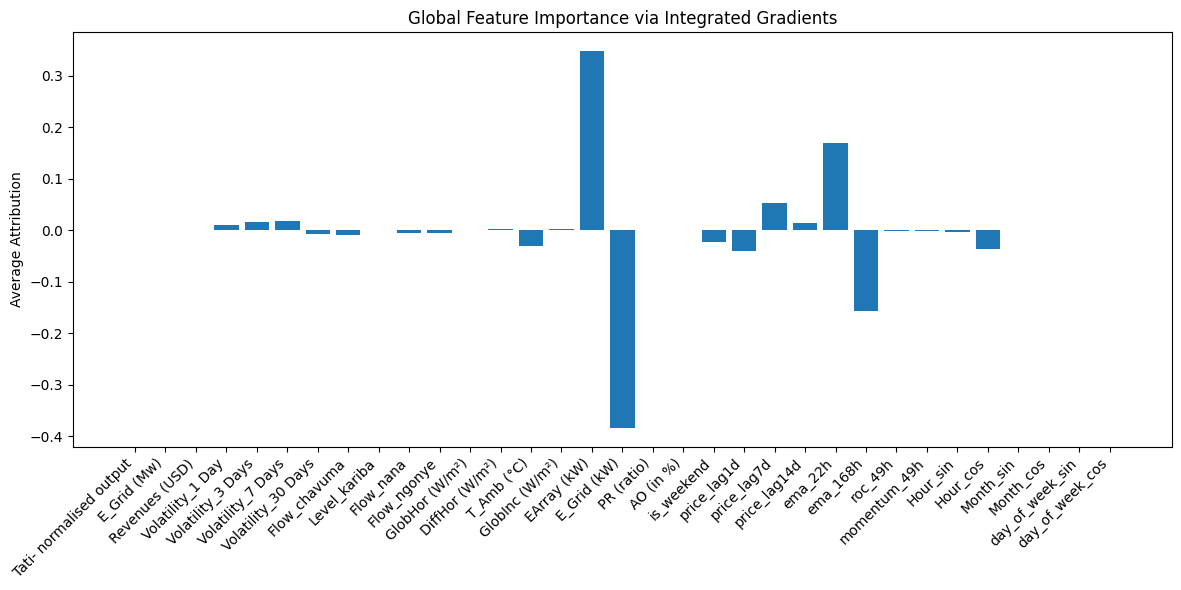

In [69]:
from captum.attr import IntegratedGradients
import torch
import numpy as np
import matplotlib.pyplot as plt

# Temporarily switch to train mode for CuDNN backward compatibility
model.train()

all_attributions = []

# Get feature names — adjust as needed to reflect correct columns
# feature_names = features.columns.tolist()
feature_names = df_scaled.drop(columns=['Price (USD/MWh)', 'target_scaled']).columns.tolist()

ig = IntegratedGradients(model)

if lookback >= 2160:
    # Lazy case — use val_loader
    for xb, _ in val_loader:
        xb = xb.to(device).requires_grad_()  # shape: (batch, time, features)
        for i in range(xb.size(0)):  # iterate through batch
            input_tensor = xb[i:i+1]  # shape: (1, time, features)
            attributions, _ = ig.attribute(input_tensor, target=0, return_convergence_delta=True)
            summed = attributions.sum(dim=1).squeeze().detach().cpu().numpy()  # sum across time
            all_attributions.append(summed)

else:
    # Non-lazy case — use X_val directly
    for i in range(len(X_val)):
        input_tensor = torch.tensor(X_val[i:i+1], dtype=torch.float32, requires_grad=True).to(device)
        attributions, _ = ig.attribute(input_tensor, target=0, return_convergence_delta=True)
        summed = attributions.sum(dim=1).squeeze().detach().cpu().numpy()
        all_attributions.append(summed)

model.eval()
# Average across all samples
avg_attr = np.mean(np.stack(all_attributions), axis=0)

# Plot global feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_names, avg_attr, color='darkorange')  # Set bar color
plt.axhline(0, color='gray', linewidth=0.2, linestyle='-')  # Horizontal line at y=0
plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Attribution")
plt.title("Global Feature Importance For LSTM")
plt.tight_layout()
plt.show()


The global interpretation aggregates feature attributions across many samples to show which inputs the model relies on most consistently. By averaging importance scores, it highlights the overall influence of each feature on predictions—revealing patterns such as persistent reliance on long-term volatility or cyclical time features. This offers a high-level understanding of the model’s behavior and helps validate that it aligns with domain knowledge.